In [11]:
from sympy import Integer, Function, Derivative, Eq, symbols
from sympkf import FDModelBuilder, SymbolicPKF

In [14]:
x, t = symbols('x t')
u = Function('u')(t, x)
c = Function('c')(t,x)

dynamics = [Eq(Derivative(c,t), u*Derivative(c,x)), Eq(Derivative(u,t),0)]
pkf_advection = SymbolicPKF(dynamics)

In [15]:


g = pkf_advection.fields[u].metric[0] # metric tensor
s = pkf_advection.fields[u].aspect[0] # aspect tensor

# loc. Gaussian closure of P18 in metric form, then in aspect form
P18_closure = Integer(3)*g**Integer(2)-Integer(2)*Derivative(g,x,2)
P18_closure = P18_closure.subs(g,1/s).doit().expand()

# Introduction of the closure as a dictionnary
unclosed_term = list(pkf_advection.unclosed_terms)[0]
pkf_advection.set_closure({unclosed_term:P18_closure})

# Build a numerical code at runtime
exec(FDModelBuilder(pkf_advection.in_aspect, class_name='ClosedPKFAdvection').code)
closed_pkf_advection = ClosedPKFAdvection(shape=(241,))

In [16]:
import matplotlib.pyplot as plt

In [17]:
def plot_results(data, label=None, labelx=True, title=None, save_file=None, normalisation=None, 
                 selected_times=None,style=None, name=None, alpha=1., bolds=[0., 1.]):
    
    normalisation = 1. if normalisation is None else normalisation
                 
    selected_times = [time for time in data] if selected_times is None else selected_times
                 
    style = 'k' if style is None else style
                 
    for time in selected_times:
        lalpha = alpha if time in bolds else 0.2
        lname = name if time==selected_times[-1] else None
        plt.plot(domain.x[0],data[time]/normalisation, style, alpha = lalpha, label=lname)
                 
    if labelx:
        plt.xlabel('$x/D$', fontsize=15)
    if label:
        plt.ylabel(label, fontsize=15)
    if title:
        plt.title(title)
    if save_file:
        plt.savefig(save_file)

In [18]:
domain = closed_pkf_advection

In [184]:
def matrix_correlation(lhc, lhu):
    gauss_c = lambda dx : np.exp(-0.5*dx**2/lhc**2)
    gauss_u = lambda dx : np.exp(-0.5*dx**2/lhu**2)
    gauss_cu = lambda dx : np.exp(-0.5*dx**2/(lhu*lhc))
    
    g = []
    
    gc = gauss_c(domain.x[0]-domain.x[0][domain.shape[0]//2])
    gu = gauss_u(domain.x[0]-domain.x[0][domain.shape[0]//2])
    gcu = gauss_cu(domain.x[0]-domain.x[0][domain.shape[0]//2])
    
    dx = domain.x[0][1]
    n = domain.shape[0]
    
    correlation = np.zeros((2*n,2*n))
    
    for i in range(n):
        correlation[i][0:domain.shape[0]] = np.roll(gc, domain.shape[0]//2-i)
        correlation[i][domain.shape[0]:] = np.roll(gcu, domain.shape[0]//2-i)
    for i in range(n,2*n):
        correlation[i][0:domain.shape[0]] = np.roll(gcu, domain.shape[0]//2-i)
        correlation[i][domain.shape[0]:] = np.roll(gu, domain.shape[0]//2-i)
    return correlation

In [190]:
lh = 0.2
lh2 = 0.04

Pf = matrix_correlation(lh,lh2)

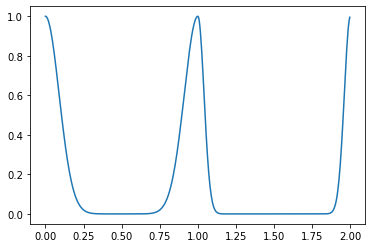

In [191]:
d = np.concatenate((domain.x[0], 1+ domain.x[0]))
d
plt.plot(d, Pf[481])